# Face verification using Siamese Networks

### Goals
- train a network for face similarity using siamese networks
- work data augmentation, generators and hard negative mining
- use the model on your picture


### Dataset

- We will be using Labeled Faces in the Wild (LFW) dataset available openly at http://vis-www.cs.umass.edu/lfw/
- For computing purposes, we'll only restrict ourselves to a subpart of the dataset. You're welcome to train on the whole dataset on GPU, by setting `USE_SUBSET=False` in the following cells,
- We will also load pretrained weights


In [ ]:
%%capture

!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz && tar xvzf lfw-deepfunneled.tgz

In [ ]:
%%capture

!pip install tensorflow matplotlib scikit-learn scikit-image imgaug mlflow boto3

In [ ]:
import os
import random
import itertools
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Lambda, Dot
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import mlflow

plt.style.use('dark_background')

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import tensorflow as tf

In [ ]:
#@title Paramètres MLFlow { display-mode: "form" }
mlflow_tracking_uri = "https://mlflow-iasd.herokuapp.com" #@param {type:"string"}
experiment_name = "t.ricatte" #@param {type:"string"}

mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment(experiment_name)

In [ ]:
class MLFlowCallback(tf.keras.callbacks.Callback):

    def __init__(self):
      self.epoch_test = 0
      super().__init__()

    def on_epoch_end(self, epoch, logs=None):
      for key in logs:
        mlflow.log_metric(f"{key}_train", logs[key], step=epoch)

    def on_test_end(self, logs=None):
      for key in logs:
        mlflow.log_metric(f"{key}_test", logs[key], step=self.epoch_test)
      self.epoch_test += 1

## Processing the dataset

The dataset consists of folders corresponding to each identity. The folder name is the name of the person.
We map each class (identity) to an integer id, and build mappings as dictionaries `name_to_classid` and `classid_to_name`

In [ ]:
PATH = "lfw-deepfunneled/"
USE_SUBSET = True

In [ ]:
dirs = sorted(os.listdir(PATH))
if USE_SUBSET:
    dirs = dirs[:500]

#dictionaries {keys:values}
name_to_classid = {d: i for i, d in enumerate(dirs)} 
classid_to_name = {v: k for k, v in name_to_classid.items()}
num_classes = len(name_to_classid)

print("number of classes: ", num_classes)

number of classes:  500


In each directory, there is one or more images corresponding to the identity. We map each image path with an integer id, then build a few dictionaries:
- mappings from imagepath and image id: `path_to_id` and `id_to_path`
- mappings from class id to image ids: `classid_to_ids` and `id_to_classid`

In [ ]:
# read all directories
img_paths = {c: [PATH + subfolder + "/" + img
                 for img in sorted(os.listdir(PATH + subfolder))] 
             for subfolder, c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_id = {v: k for k, v in enumerate(all_images_path)}
id_to_path = {v: k for k, v in path_to_id.items()}

In [ ]:
# build mappings between images and class
classid_to_ids = {k: [path_to_id[path] for path in v] for k, v in img_paths.items()}
id_to_classid = {v: c for c,imgs in classid_to_ids.items() for v in imgs}
dict(list(id_to_classid.items())[0:13])

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 5,
 7: 5,
 8: 5,
 9: 6,
 10: 7,
 11: 7,
 12: 8}

The following histogram shows the number of images per class: there are many classes with only one image. 
These classes are useful as negatives, only as we can't make a positive pair with them.

In [ ]:
[(classid_to_name[x], len(classid_to_ids[x]))
 for x in np.argsort([len(v) for k,v in classid_to_ids.items()])[::-1][:10]]

[('Ariel_Sharon', 77),
 ('Arnold_Schwarzenegger', 42),
 ('Alejandro_Toledo', 39),
 ('Andre_Agassi', 36),
 ('Alvaro_Uribe', 35),
 ('Atal_Bihari_Vajpayee', 24),
 ('Amelie_Mauresmo', 21),
 ('Angelina_Jolie', 20),
 ('Abdullah_Gul', 19),
 ('Andy_Roddick', 15)]

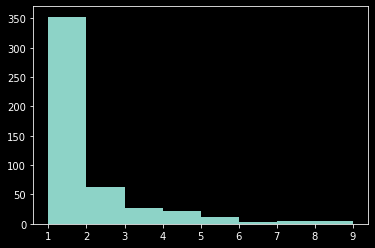

In [ ]:
plt.hist([len(v) for k,v in classid_to_ids.items()], bins=range(1,10))
plt.show()

In [ ]:

# np.argsort  returns the indices that would sort an array
[(classid_to_name[x], len(classid_to_ids[x]))
 for x in np.argsort([len(v) for k,v in classid_to_ids.items()])[::-1][:10]]#x is apparently the index of the the table that contains len(ids) sorted

[('Ariel_Sharon', 77),
 ('Arnold_Schwarzenegger', 42),
 ('Alejandro_Toledo', 39),
 ('Andre_Agassi', 36),
 ('Alvaro_Uribe', 35),
 ('Atal_Bihari_Vajpayee', 24),
 ('Amelie_Mauresmo', 21),
 ('Angelina_Jolie', 20),
 ('Abdullah_Gul', 19),
 ('Andy_Roddick', 15)]

In [ ]:
from skimage.io import imread
from skimage.transform import resize


#for resizing images
def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True)[20:80,20:80,:]

def resize224(img):
    return resize(img, (224, 224), preserve_range=True, mode='reflect', anti_aliasing=True)

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        all_imgs += [np.expand_dims(resize224(imread(path)),0)]
    return np.vstack(all_imgs)

In [ ]:
all_imgs = open_all_images(id_to_path)#opens all images from a path obtained from an id
all_imgs.shape

(1155, 224, 224, 3)

In [ ]:
str(all_imgs.nbytes / 1e6) + "MB" #displays the sizze of images in MegaByte

'1390.87872MB'

In [ ]:
split_ratio = 0.8
split_class = int(num_classes * split_ratio) #number of classes of the split

all_classes_randomized = list(range(0, num_classes))
np.random.shuffle(all_classes_randomized)

train_classes = all_classes_randomized[:split_class]
test_classes = all_classes_randomized[split_class:]

print(f"{len(train_classes)} classes will be used for training")
print(f"{len(test_classes)} classes will be used for testing")

400 classes will be used for training
100 classes will be used for testing


In [ ]:
train_images_ids = list()
test_images_ids = list()

for query_id in range(len(all_imgs)):
  if id_to_classid.get(query_id) in train_classes:
    train_images_ids.append(query_id)
  else:
    test_images_ids.append(query_id)

print(f"{len(train_images_ids)} images will be used for training")
print(f"{len(test_images_ids)} images will be used for testing")

991 images will be used for training
164 images will be used for testing


In [ ]:
from collections import defaultdict
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
from sklearn.manifold import TSNE
from palettable.cartocolors.qualitative import Bold_10, Antique_10

def visualize_embeddings(emb, project_on_sphere=False):
  embeddings_per_name = defaultdict(lambda: list())

  for query_id in range(len(emb)):
    class_id = id_to_classid.get(query_id)
    class_name = classid_to_name.get(class_id)

    embeddings_per_name[class_name].append(emb[query_id])#embeddings_per_name[] is therefore a list

  embeddings_per_name = {
      key: np.array(value) for key, value in embeddings_per_name.items() if len(value) > 8
  }
  #creates empty lists
  plt_emb = list()
  labels = list()

  for key, values in embeddings_per_name.items():
    plt_emb.append(values)
    for _ in range(values.shape[0]):
      labels.append(key)

  unique_labels = sorted(list(set(labels)))#set is for creating a list without duplicates

  all_colors = Bold_10.hex_colors + Antique_10.hex_colors

  colors = [all_colors[unique_labels.index(v)] for v in labels] #creates different colors for each labels


  # TSNE is  a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map
  tsne_viz = TSNE()
  plt_emb = np.vstack(plt_emb)#Stack arrays in sequence vertically (row wise).


  #on normalise par rapport à l'axe²:1
  if project_on_sphere:
    plt_emb = normalize(plt_emb, axis=1)

  plt_emb_viz = tsne_viz.fit_transform(plt_emb)
  fig = plt.figure(figsize=(20, 10))
  ax = fig.subplots()

  df = pd.DataFrame({
      "x": plt_emb_viz[:,0],
      "y": plt_emb_viz[:,1],
      "c": colors,
      "train": [1 if name_to_classid.get(l) in train_classes else 0 for l in labels]
  })

  df_train = df.query(f"train==1")
  df_test = df.query(f"train==0")

  ax.scatter(df_train.x, df_train.y, c = df_train.c, s=40, marker="x")
  ax.scatter(df_test.x, df_test.y, c = df_test.c, s=40, marker="o")
  
  legend_elements = [Patch(facecolor=all_colors[i],
                         label=f"{name} (train)" if name_to_classid.get(name) in train_classes else f"{name} (test)") for i, name in enumerate(unique_labels)]

  ax.legend(handles=legend_elements)
  fig.show()



### Multi-class classification


In [ ]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    # You can add more transformation like random rotations, random change of luminance, etc.
])

In [ ]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, batch_size, image_ids):
        self.batch_size = batch_size
        self.image_ids = np.array(image_ids)
        self.num_samples = len(self.image_ids)
        self.indices = np.array(range(0, self.num_samples))
        np.random.shuffle(self.indices)
        
    def __len__(self):
        return self.num_samples // self.batch_size
        
    def __getitem__(self, batch_index):
        """This method returns the `batch_index`-th batch of the dataset.
        
        Keras choose by itself the order in which batches are created, and several may be created
        in the same time using multiprocessing. Therefore, avoid any side-effect in this method!
        """
        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size
        batch_indices = self.indices[low_index:high_index] 
        batch_image_ids = self.image_ids[batch_indices]

        imgs = seq.augment_images(all_imgs[batch_image_ids])
        targets = np.array([id_to_classid.get(idx) for idx in batch_image_ids])
    
        return (imgs, targets)

    def on_epoch_end(self):
        print("Shuffling indices")
        np.random.shuffle(self.indices)

In [ ]:
gen = Generator(batch_size=32, image_ids=train_images_ids)

In [ ]:
enet = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling="avg")# I think it's a  pretrained model for transfer learning
enet.trainable = False

#create the first layers of the architecture
feature_extractor = tf.keras.Sequential([
    enet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50)
])

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
#merge the top layers and the pretrained model
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes)
])
print(model.predict(all_imgs[:10]).shape)

model.summary()

(10, 500)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 50)                4113621   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               25500     
Total params: 4,139,121
Trainable params: 89,550
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=5e-2), metrics=["accuracy"])

In [ ]:

#The MLflow Tracking component is an API and UI for logging parameters, code versions, metrics, 
#and output files when running your machine learning code and for later visualizing the results.
# MLflow Tracking lets you log and query experiments using Python, REST, R API, and Java API APIs.
with mlflow.start_run(run_name="multiclass"):
  model.fit_generator(generator=gen, verbose=2, callbacks=[MLFlowCallback()], epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
30/30 - 11s - loss: 14.9962 - accuracy: 0.0104
Shuffling indices
Epoch 2/10
30/30 - 4s - loss: 15.4632 - accuracy: 0.0198
Shuffling indices
Epoch 3/10
30/30 - 4s - loss: 15.4240 - accuracy: 0.0208
Shuffling indices
Epoch 4/10
30/30 - 4s - loss: 15.4205 - accuracy: 0.0198
Shuffling indices
Epoch 5/10
30/30 - 4s - loss: 15.5019 - accuracy: 0.0198
Shuffling indices
Epoch 6/10
30/30 - 4s - loss: 15.4472 - accuracy: 0.0198
Shuffling indices
Epoch 7/10
30/30 - 4s - loss: 15.4733 - accuracy: 0.0188
Shuffling indices
Epoch 8/10
30/30 - 4s - loss: 15.4512 - accuracy: 0.0198
Shuffling indices
Epoch 9/10
30/30 - 4s - loss: 15.4014 - accuracy: 0.0198
Shuffling indices
Epoch 10/10
30/30 - 4s - loss: 15.4438 - accuracy: 0.0208
Shuffling indices


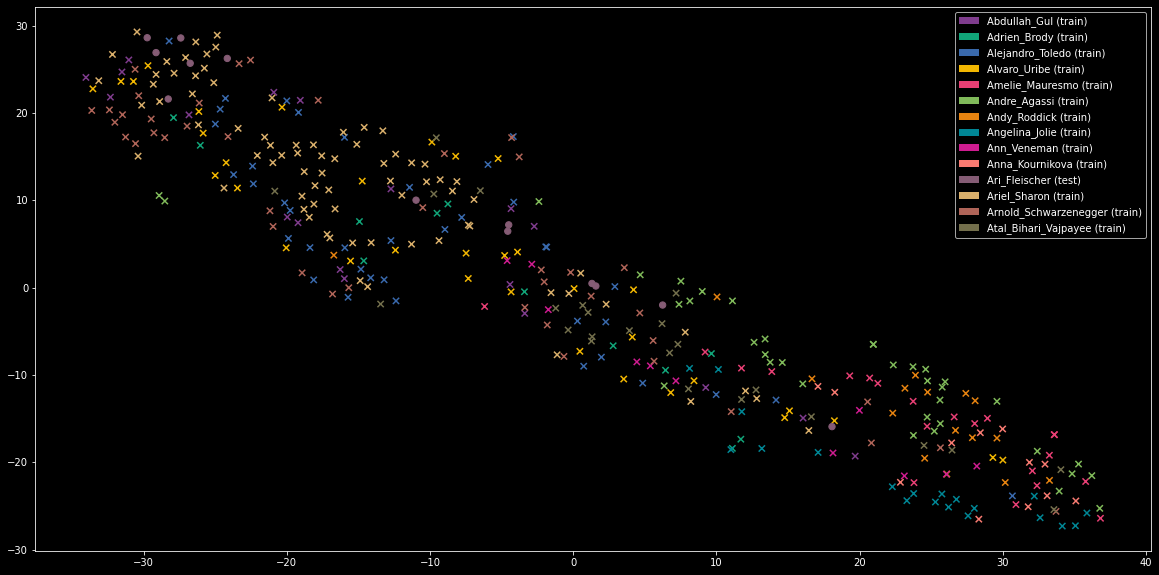

In [ ]:
# Visualize the feature extractor on a few identities with enough samples
emb = feature_extractor.predict(all_imgs, batch_size=32)
visualize_embeddings(emb)

### Siamese nets

A siamese net takes as input two images $x_1$ and $x_2$ and outputs a single value which corresponds to the similarity between $x_1$ and $x_2$.


In order to train such a system, one has to build positive and negative pairs for the training. 

In [ ]:
# build pairs of positive image ids for a given classid
def build_pos_pairs_for_id(classid, max_num=50):
    imgs = classid_to_ids[classid]#on sélectionne les images d'une même classe
    
    if len(imgs) == 1:
        return []

    pos_pairs = list(itertools.combinations(imgs, 2))#itertools.combinations crée des combinaisons de deux images 
    
    random.shuffle(pos_pairs)#shuffle reorganizes the order of the list passed in argument
    return pos_pairs[:max_num]

In [ ]:
# build pairs of negative image ids for a given classid
def build_neg_pairs_for_id(classid, classes, max_num=20):
    imgs = classid_to_ids[classid]
    neg_classes_ids = random.sample(classes, max_num+1)# random sample returns a particular length list of items chosen from the sequence
    
    if classid in neg_classes_ids:
        neg_classes_ids.remove(classid)#on l'enlève pour qu'on n'aie pas 2 mêmes classes 
        
    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0,len(imgs)-1)]#on sélectionne  la première image
        imgs2 = classid_to_ids[neg_classes_ids[id2]]#on sélectionne une liste d'ids d'images??
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]
        
    return neg_pairs

Let's build positive and a negative pairs for class 5

In [ ]:
build_pos_pairs_for_id(5, 20)

[(6, 8), (5, 6), (6, 7), (7, 8), (5, 8), (5, 7)]

In [ ]:
build_neg_pairs_for_id(5, list(range(num_classes)), 6)

[(5, 973), (6, 583), (5, 78), (8, 215), (5, 387), (5, 321)]

The following function builds a large number of positives/negatives pairs (train and test)

In [ ]:
def build_train_test_data():
    listX1 = []
    listX2 = []
    listY = []
    split = split_class
    
    # train
    for class_id in train_classes:
        pos = build_pos_pairs_for_id(class_id)
        neg = build_neg_pairs_for_id(class_id, train_classes)
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    perm = np.random.permutation(len(listX1))
    X1_ids_train = np.array(listX1)[perm]
    X2_ids_train = np.array(listX2)[perm]
    Y_ids_train = np.array(listY)[perm]
    
    listX1 = []
    listX2 = []
    listY = []
    
    #test
    for id in test_classes:
        pos = build_pos_pairs_for_id(id)
        neg = build_neg_pairs_for_id(id, test_classes)
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_test = np.array(listX1)
    X2_ids_test = np.array(listX2)
    Y_ids_test = np.array(listY)
    return (X1_ids_train, X2_ids_train, Y_ids_train,
            X1_ids_test, X2_ids_test, Y_ids_test)

In [ ]:
X1_ids_train, X2_ids_train, train_Y, X1_ids_test, X2_ids_test, test_Y = build_train_test_data()

In [ ]:
X1_ids_train.shape, X2_ids_train.shape, train_Y.shape

((2350,), (2350,), (2350,))

In [ ]:
np.mean(train_Y)

0.5

In [ ]:
X1_ids_test.shape, X2_ids_test.shape, test_Y.shape

((302,), (302,), (302,))

In [ ]:
np.mean(test_Y)

0.5

**Data augmentation and generator**

We're building a generator, which will modify images through dataaugmentation on the fly. 
The generator enables
We use iaa library which offers tremendous possibilities for data augmentation


In [ ]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    # You can add more transformation like random rotations, random change of luminance, etc.
])

In [ ]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, X1, X2, Y, batch_size, all_imgs):
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]

        self.indices = np.array(range(0, self.num_samples))
        np.random.shuffle(self.indices)

        
    def __len__(self):
        return self.num_samples // self.batch_size
        
    def __getitem__(self, batch_index):
        """This method returns the `batch_index`-th batch of the dataset.
        
        Keras choose by itself the order in which batches are created, and several may be created
        in the same time using multiprocessing. Therefore, avoid any side-effect in this method!
        """
        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size
        batch_indices = self.indices[low_index:high_index]
        
        imgs1 = seq.augment_images(self.imgs[self.X1[batch_indices]])
        imgs2 = seq.augment_images(self.imgs[self.X2[batch_indices]])
        targets = self.Y[batch_indices]
    
        return ([imgs1, imgs2], targets)

    def on_epoch_end(self):
        print("Shuffling indices")
        np.random.shuffle(self.indices)

In [ ]:
gen = Generator(X1_ids_train, X2_ids_train, train_Y, 32, all_imgs)

In [ ]:
print("Number of batches: {}".format(len(gen)))

Number of batches: 73


In [ ]:
[x1, x2], y = gen[0]

x1.shape, x2.shape, y.shape

((32, 224, 224, 3), (32, 224, 224, 3), (32,))

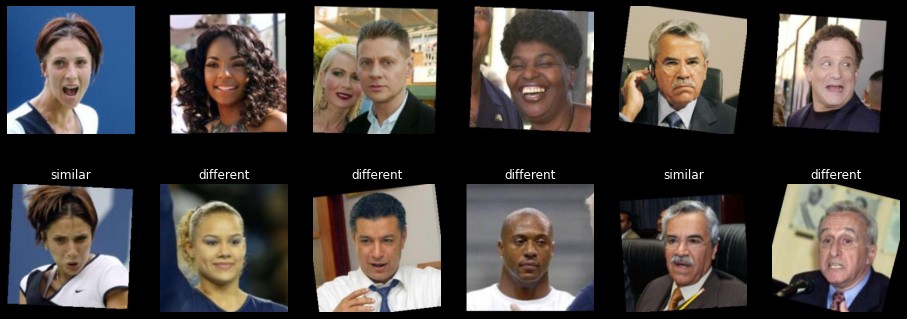

In [ ]:
plt.figure(figsize=(16, 6))

for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(x1[i] / 255)
    plt.axis('off')
    
for i in range(6):
    plt.subplot(2, 6, i + 7)
    plt.imshow(x2[i] / 255)
    if y[i]==1.0:
        plt.title("similar")
    else:
        plt.title("different")
    plt.axis('off')
    
plt.show()

**Exercise**
- Add your own dataaugmentations in the process. You may look at: http://imgaug.readthedocs.io for instance use `iaa.Affine`;
- Be careful not to make the task to difficult, and to add meaningful augmentations;
- Rerun the generator plot above to check whether the image pairs look not too distorted to recognize the identities.

** Test images **

- In addition to our generator, we need test images, unaffected by the augmentation

In [ ]:
test_X1 = all_imgs[X1_ids_test]
test_X2 = all_imgs[X2_ids_test]

In [ ]:
test_X1.shape, test_X2.shape, test_Y.shape

((302, 224, 224, 3), (302, 224, 224, 3), (302,))

In [ ]:
@tf.function
def contrastive_loss(y_true, y_pred, margin=0.25):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    y_true = tf.cast(y_true, "float32")
    return tf.reduce_mean( y_true * tf.square(1 - y_pred) +
                  (1 - y_true) * tf.square(tf.maximum(y_pred - margin, 0)))

In [ ]:
@tf.function
def accuracy_sim(y_true, y_pred, threshold=0.5):
    '''Compute classification accuracy with a fixed threshold on similarity.
    '''
    y_thresholded = tf.cast(y_pred > threshold, "float32")
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_thresholded), "float32"))

**Exercise**
- Build a convolutional model which transforms the input to a fixed dimension $d = 50$
- You may alternate convolutions and maxpooling and layers,
- Use the relu activation on convolutional layers,
- At the end, `Flatten` the last convolutional output and plug it into a dense layer.
- Feel free to use some `Dropout` prior to the Dense layer.

Use between 32 and 128 channels on convolutional layers. Be careful: large convolutions on high dimensional images can be very slow on CPUs.

Try to run your randomly initialized `shared_conv`  model on a batch of the first 10 images from `all_imgs`. What is the expected shape of the output?

In [ ]:
enet = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling="avg")
enet.trainable = False#we freeze the pre-trained model

feature_extractor = tf.keras.Sequential([
    enet,
    tf.keras.layers.Flatten(),#we add a flatten layer
    tf.keras.layers.Dense(50)#we plug the flattened layer in a  d=50
])

In [ ]:
print(feature_extractor.predict(all_imgs[:10], batch_size=32).shape)
feature_extractor.summary()

(10, 50)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                64050     
Total params: 4,113,621
Trainable params: 64,050
Non-trainable params: 4,049,571
_________________________________________________________________


**Exercise**

Assemble the siamese model by combining:

- `shared_conv` on both inputs;
- compute the cosine similarity using the [Dot](https://keras.io/layers/merge/#dot) layer with `normalize=True` on the outputs of the two `shared_conv` instance lanes;
- the loss of siamese model is the constrastive loss defined previously;
- use the `accuracy_sim` function defined previously as a metric.
    

In [ ]:
class Siamese(tf.keras.Model):
    def __init__(self, shared_conv):
        super().__init__(self, name="siamese")
        self.shared_conv = shared_conv
        self.cosine = tf.keras.layers.Dot(normalize=True, axes=1) #Layer that computes a dot product between samples in two tensors.


        
    def call(self, inputs):
        embeddings = [self.shared_conv(x) for x in inputs]
        return self.cosine([embeddings[0], embeddings[1]])

In [ ]:
model = Siamese(feature_extractor)#feature extractor =enet+flatten+dense
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy_sim])

We can now fit the model and checkpoint it to keep the best version. We can expect to get a model with around 0.75 as "accuracy_sim" on the validation set:

In [ ]:
with mlflow.start_run(run_name="siamese"):

  mlflow.log_param("nb_params", feature_extractor.count_params())

  model.fit_generator(generator=gen, 
                      epochs=10,
                      validation_data=([test_X1, test_X2], test_Y),
                      callbacks=[MLFlowCallback()],
                      verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
73/73 - 37s - loss: 0.0943 - accuracy_sim: 0.7183 - val_loss: 0.0920 - val_accuracy_sim: 0.6777
Shuffling indices
Epoch 2/10
73/73 - 20s - loss: 0.0603 - accuracy_sim: 0.8369 - val_loss: 0.0977 - val_accuracy_sim: 0.7558
Shuffling indices
Epoch 3/10
73/73 - 19s - loss: 0.0462 - accuracy_sim: 0.8767 - val_loss: 0.1010 - val_accuracy_sim: 0.7589
Shuffling indices
Epoch 4/10
73/73 - 19s - loss: 0.0384 - accuracy_sim: 0.9045 - val_loss: 0.0941 - val_accuracy_sim: 0.7152
Shuffling indices
Epoch 5/10
73/73 - 19s - loss: 0.0328 - accuracy_sim: 0.9277 - val_loss: 0.0972 - val_accuracy_sim: 0.7205
Shuffling indices
Epoch 6/10
73/73 - 19s - loss: 0.0281 - accuracy_sim: 0.9392 - val_loss: 0.0921 - val_accuracy_sim: 0.7536
Shuffling indices
Epoch 7/10
73/73 - 20s - loss: 0.0243 - accuracy_sim: 0.9525 - val_loss: 0.0900 - val_accuracy_sim: 0.7652
Shuffling indices
Epoch 8/10
73/73 - 20s - loss: 0.0217 - accuracy_sim: 0.9645 - val_loss: 0.1083 - val_accuracy_sim: 0.7754
Shuffling indices


**Exercise**

Finding the most similar images by building a `most_sim` function which returns the most similar vectors to a given vector.

In [ ]:
# Running the feature extractor on all images
emb = model.shared_conv.predict(all_imgs, batch_size=32)

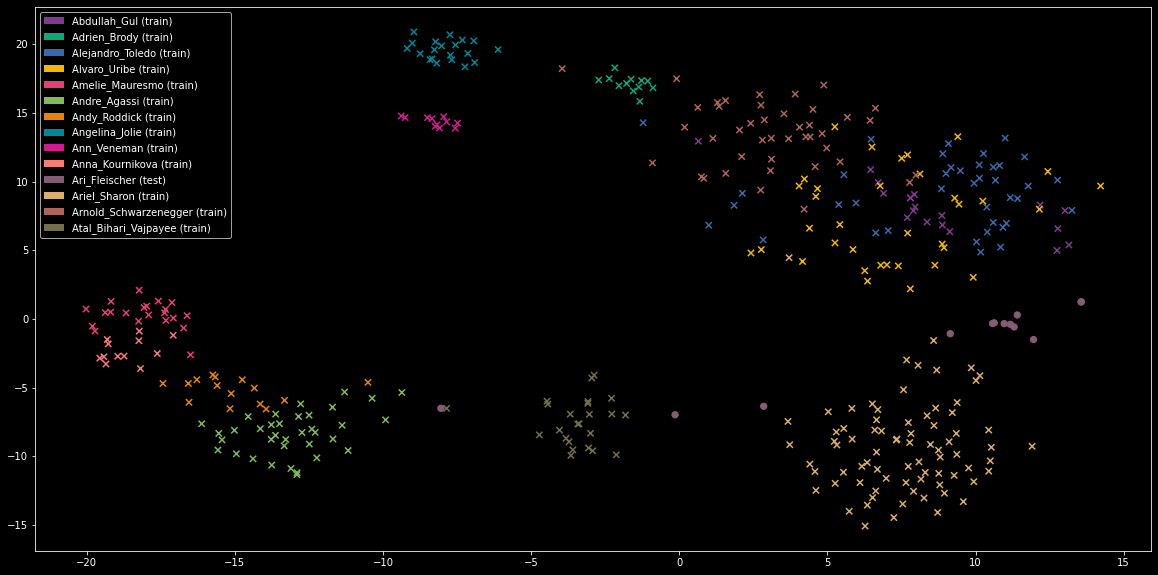

In [ ]:
visualize_embeddings(emb)

In [ ]:
def most_sim(x, emb, topn=3, skip_class=None):
  """
  x: the input embedding
  emb: the list of all embeddings
  skip_class: (opt) the classid of x to be skipped
              (if we want similar images of a different class)
  """
  dot = tf.keras.layers.Dot(normalize=True, axes=1)

  ret = list()

  for i, candidate_emb in enumerate(emb):
    sim = dot([tf.expand_dims(x, 0), tf.expand_dims(candidate_emb, 0)])

    ret.append((i, sim))

  if skip_class is not None:
    ret = [(result_id, sim)
            for result_id, sim in ret
            if id_to_classid.get(result_id)!=skip_class]
  
  ret = sorted(ret, key=lambda s: s[1])[-topn:]

  return ret

** Most similar faces **

The following enables to display an image alongside with most similar images:

- The results are weak, first because of the size of the dataset
- Also, the network can be greatly improved

In [ ]:
def display(img):
    img = img.astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

query: Andre_Agassi 559


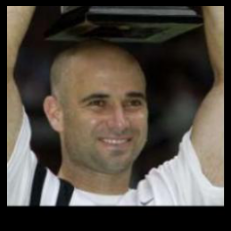

nearest matches
Atal_Bihari_Vajpayee 1017 tf.Tensor([[0.74522185]], shape=(1, 1), dtype=float32)


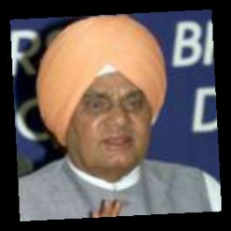

Atal_Bihari_Vajpayee 1010 tf.Tensor([[0.76081884]], shape=(1, 1), dtype=float32)


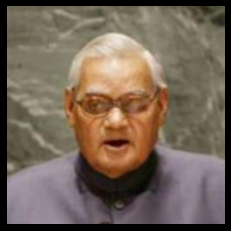

Atal_Bihari_Vajpayee 1007 tf.Tensor([[0.7733979]], shape=(1, 1), dtype=float32)


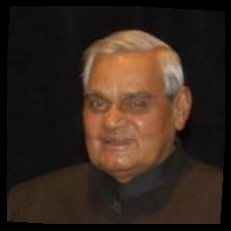

In [ ]:
interesting_classes = list(filter(lambda x: len(x[1]) > 4, classid_to_ids.items()))
class_id = random.choice(interesting_classes)[0]

query_id = random.choice(classid_to_ids[class_id])
print("query:", classid_to_name[class_id], query_id)
display(all_imgs[query_id])

print("nearest matches")
for result_id, sim in most_sim(emb[query_id], emb, skip_class=class_id):
    class_name = classid_to_name.get(id_to_classid.get(result_id))
    print(class_name, result_id, sim)    
    display(all_imgs[result_id])

# Triplet loss

In the triplet loss model, we'll define 3 inputs $(a,+,-)$ for anchor, positive and negative.

#### Usage and differences with siamese nets

We release the hard constraint that all data of the same class should be squashed to a single point. Rather, images representation can live on a manifold, as long as they are closer to similar class images than to different class images

On large datasets, with careful hyperparameters, triplets and more advances metric learning method beat siamese nets

#### Outline

We will build positive pairs, and find a way to sample negatives to obtain triplets
Note that we don't need outputs anymore (positive vs negative), we're just building triplets

In [ ]:
def build_pos_pairs_for_id(classid, max_num=50):
    imgs = classid_to_ids[classid]
    if len(imgs) == 1:
        return []
    
    pos_pairs = list(itertools.combinations(imgs, 2))
    
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]


In [ ]:
def build_positive_pairs(class_id_range):
    listX1 = []
    listX2 = []
    
    for class_id in class_id_range:
        pos = build_pos_pairs_for_id(class_id)
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            
    perm = np.random.permutation(len(listX1))
    return np.array(listX1)[perm], np.array(listX2)[perm]

In [ ]:
Xa_train, Xp_train = build_positive_pairs(train_classes)
Xa_test, Xp_test = build_positive_pairs(test_classes)

# Gather the ids of all images that are used for train and test
all_img_train_idx = list(set(Xa_train) | set(Xp_train))
all_img_test_idx = list(set(Xa_test) | set(Xp_test))

For each pair we use a random sample (as negative) in the generator

In [ ]:
Xa_train.shape, Xp_train.shape

((1175,), (1175,))

In [ ]:
class TripletGenerator(tf.keras.utils.Sequence):
    def __init__(self, Xa_train, Xp_train, batch_size, all_imgs, neg_imgs_idx):
        self.cur_img_index = 0
        self.cur_img_pos_index = 0
        self.batch_size = batch_size
        
        self.imgs = all_imgs
        self.Xa = Xa_train  # Anchors
        self.Xp = Xp_train
        self.cur_train_index = 0
        self.num_samples = Xa_train.shape[0]
        self.neg_imgs_idx = neg_imgs_idx

        self.indices = np.array(range(0, self.num_samples))
        np.random.shuffle(self.indices)
        
    def __len__(self):
        return self.num_samples // self.batch_size
        
    def __getitem__(self, batch_index):
        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size
        batch_indices = self.indices[low_index:high_index]

        imgs_a = self.Xa[batch_indices]  # Anchors
        imgs_p = self.Xp[batch_indices]  # Positives
        imgs_n = random.sample(self.neg_imgs_idx, imgs_a.shape[0])  # Negatives
            
        imgs_a = seq.augment_images(self.imgs[imgs_a])
        imgs_p = seq.augment_images(self.imgs[imgs_p])
        imgs_n = seq.augment_images(self.imgs[imgs_n])
            
        # We also a null vector as placeholder for output, but it won't be needed:
        return ([imgs_a, imgs_p, imgs_n], np.zeros(shape=(imgs_a.shape[0])))

    def on_epoch_end(self):
        print("Shuffling indices")
        np.random.shuffle(self.indices)

In [ ]:
batch_size = 128
gen = TripletGenerator(Xa_train, Xp_train, batch_size, all_imgs, all_img_train_idx)

In [ ]:
len(all_img_test_idx), len(gen)

(93, 9)

In [ ]:
[xa, xp, xn], y = gen[0]

xa.shape, xp.shape, xn.shape

((128, 224, 224, 3), (128, 224, 224, 3), (128, 224, 224, 3))

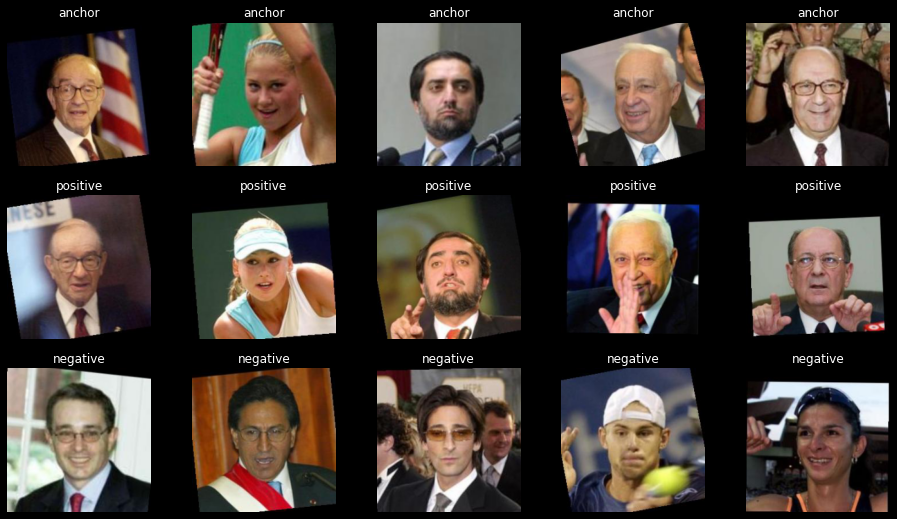

In [ ]:
plt.figure(figsize=(16, 9))

for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.title("anchor")
    plt.imshow(xa[i].astype('uint8'))
    plt.axis('off')
    
for i in range(5):
    plt.subplot(3, 5, i + 6)
    plt.title("positive")
    plt.imshow(xp[i].astype('uint8'))
    plt.axis('off')
    
for i in range(5):
    plt.subplot(3, 5, i + 11)
    plt.title("negative")
    plt.imshow(xn[i].astype('uint8'))
    plt.axis('off')
    
plt.show()

As you can see, choosing randomly the negatives can be inefficient. For example it's reasonnable to think a old man will be a too easy negative if the anchor is a young woman.

In [ ]:
gen_test = TripletGenerator(Xa_test, Xp_test, 32, all_imgs, all_img_test_idx)
len(gen_test)

4

## Triplet Model

The loss of the triplet model is as follows: 

$$ max(0, ||x_a - x_p||_2 - ||x_a - x_n||_2 + \alpha)$$

We'll be using cosine similarities instead of euclidean distances (seems to be working a bit better in that case), so the loss becomes:

$$ max(0, cos(x_a, x_n) - cos(x_a - x_p) + \alpha)$$


**Exercise**

- Build the triplet model, using the skeleton below using the OOP Keras API
- First run the 3 inputs through the shared conv
- Then compute positive and negative similarities
- You can compute the loss directly since you don't need any external label !! (use an identity loss for keras)

In [ ]:
import tensorflow.keras.backend as K

class TripletNetwork(tf.keras.Model):


    def __init__(self, my_conv_model):
      super().__init__(self, name="triplets")
      self.my_conv_model = my_conv_model
      self.my_dot = tf.keras.layers.Dot(normalize=True, axes=1)

    def call(self, inputs):
      x_a = inputs[0]
      x_p = inputs[1]
      x_n = inputs[2]

      f_theta_a = self.my_conv_model(x_a)
      f_theta_p = self.my_conv_model(x_p)
      f_theta_n = self.my_conv_model(x_n)

      # Compute the loss
      margin = 0.3
      sim_a_p = self.my_dot([f_theta_a, f_theta_p])
      sim_a_n = self.my_dot([f_theta_a, f_theta_n])
      loss = K.maximum(0.0, margin + sim_a_n - sim_a_p)

      return loss

def identity_loss(y_true, y_pred):
  return K.mean(y_pred)

In [ ]:
enet = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling="avg")
enet.trainable = False

feature_extractor = tf.keras.Sequential([
    enet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50)
])

In [ ]:
model = TripletNetwork(my_conv_model=feature_extractor)
model.compile(loss=identity_loss, optimizer="adam", metrics=[])

In [ ]:
with mlflow.start_run(run_name="triplets"):

  mlflow.log_param("nb_params", feature_extractor.count_params())

  history = model.fit_generator(generator=gen,
                    epochs=10,
                    validation_data = gen_test,
                    callbacks=[MLFlowCallback()])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
9/9 [==============================] - 39s 2s/step - loss: 0.1933 - val_loss: 0.1801
Shuffling indices
Epoch 2/10
9/9 [==============================] - 14s 2s/step - loss: 0.1170 - val_loss: 0.1401
Shuffling indices
Epoch 3/10
9/9 [==============================] - 14s 2s/step - loss: 0.0971 - val_loss: 0.1692
Shuffling indices
Epoch 4/10
9/9 [==============================] - 14s 2s/step - loss: 0.0967 - val_loss: 0.1626
Shuffling indices
Epoch 5/10
9/9 [==============================] - 14s 2s/step - loss: 0.0816 - val_loss: 0.1652
Shuffling indices
Epoch 6/10
9/9 [==============================] - 14s 2s/step - loss: 0.0615 - val_loss: 0.1419
Shuffling indices
Epoch 7/10
9/9 [==============================] - 14s 2s/step - loss: 0.0542 - val_loss: 0.1554
Shuffling indices
Epoch 8/10
9/9 [==============================] - 14s 2s/step - loss: 0.0507 - val_loss: 0.1386
Shuffling indices
Epoch 9/10
9/9 [==============================] - 14s 2s/step - loss: 0.0411 - val_loss:

In [ ]:
emb = model.my_conv_model.predict(all_imgs, batch_size=32)

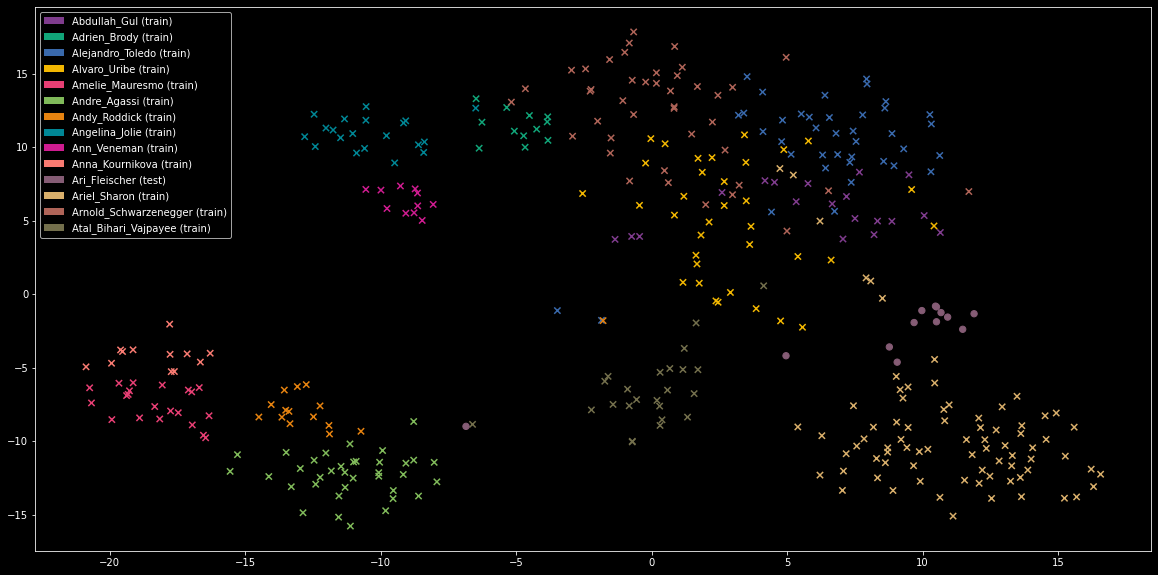

In [ ]:
visualize_embeddings(emb)

## Hard Negative Mining

We'll mine negatives based on previous epoch's model. To do so, we'll compute distances with all anchors, and sample among the most similar negatives, but not the too difficult ones

In [ ]:
# Naive way to compute all similarities between all images. May be optimized!
def build_similarities(conv, all_imgs):
    embs = conv.predict(all_imgs)
    embs = embs / np.linalg.norm(embs, axis=-1, keepdims=True)
    all_sims = np.dot(embs, embs.T)
    return all_sims

def intersect(a, b):
    return list(set(a) & set(b))

def build_negatives(anc_idxs, pos_idxs, similarities, neg_imgs_idx, num_retries=20):
    # If no similarities were computed, return a random negative
    if similarities is None:
        return random.sample(neg_imgs_idx,len(anc_idxs))
    final_neg = []
    # for each positive pair
    for (anc_idx, pos_idx) in zip(anc_idxs, pos_idxs):
        anchor_class = id_to_classid[anc_idx]
        #positive similarity
        sim = similarities[anc_idx, pos_idx]
        # find all negatives which are semi(hard)
        possible_ids = np.where((similarities[anc_idx] + 0.25) > sim)[0]
        possible_ids = intersect(neg_imgs_idx, possible_ids)
        appended = False
        for iteration in range(num_retries):
            if len(possible_ids) == 0:
                break
            idx_neg = random.choice(possible_ids)
            if id_to_classid[idx_neg] != anchor_class:
                final_neg.append(idx_neg)
                appended = True
                break
        if not appended:
            final_neg.append(random.choice(neg_imgs_idx))
    return final_neg

In [ ]:
class HardTripletGenerator(tf.keras.utils.Sequence):
    def __init__(self, Xa_train, Xp_train, batch_size, all_imgs, neg_imgs_idx, conv):
        self.batch_size = batch_size
        
        self.imgs = all_imgs
        self.Xa = Xa_train
        self.Xp = Xp_train
        self.num_samples = Xa_train.shape[0]
        self.neg_imgs_idx = neg_imgs_idx

        if conv:
            print("Pre-computing similarities...", end=" ")
            self.similarities = build_similarities(conv, self.imgs)
            print("Done!")
        else:
            self.similarities = None
        
    def __len__(self):
        return self.num_samples // self.batch_size
        
    def __getitem__(self, batch_index):
        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size
        
        imgs_a = self.Xa[low_index:high_index]
        imgs_p = self.Xp[low_index:high_index]
        imgs_n = build_negatives(imgs_a, imgs_p, self.similarities, self.neg_imgs_idx)
        
        imgs_a = seq.augment_images(self.imgs[imgs_a])
        imgs_p = seq.augment_images(self.imgs[imgs_p])
        imgs_n = seq.augment_images(self.imgs[imgs_n])
        
        return ([imgs_a, imgs_p, imgs_n], np.zeros(shape=(imgs_a.shape[0])))

In [ ]:
gen_hard = HardTripletGenerator(Xa_train, Xp_train, 128, all_imgs, all_img_train_idx, feature_extractor)
len(gen_hard)

Pre-computing similarities... Done!


9

In [ ]:
[xa, xp, xn], y = gen_hard[0]
xa.shape, xp.shape, xn.shape

((128, 224, 224, 3), (128, 224, 224, 3), (128, 224, 224, 3))

In [ ]:
with mlflow.start_run(run_name="triplets_hard"):

  mlflow.log_param("nb_params", feature_extractor.count_params())

  history = model.fit_generator(generator=gen_hard,
                    epochs=10,
                    validation_data = gen_test,
                    callbacks=[MLFlowCallback()])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
9/9 [==============================] - 14s 2s/step - loss: 0.1501 - val_loss: 0.1398
Epoch 2/10
9/9 [==============================] - 14s 2s/step - loss: 0.1251 - val_loss: 0.1600
Epoch 3/10
9/9 [==============================] - 14s 2s/step - loss: 0.0920 - val_loss: 0.1283
Epoch 4/10
9/9 [==============================] - 14s 2s/step - loss: 0.0676 - val_loss: 0.1204
Epoch 5/10
9/9 [==============================] - 14s 2s/step - loss: 0.0540 - val_loss: 0.1334
Epoch 6/10
9/9 [==============================] - 14s 2s/step - loss: 0.0448 - val_loss: 0.1358
Epoch 7/10
9/9 [==============================] - 14s 2s/step - loss: 0.0371 - val_loss: 0.1267
Epoch 8/10
9/9 [==============================] - 14s 2s/step - loss: 0.0387 - val_loss: 0.1330
Epoch 9/10
9/9 [==============================] - 14s 1s/step - loss: 0.0354 - val_loss: 0.1328
Epoch 10/10
9/9 [==============================] - 14s 2s/step - loss: 0.0279 - val_loss: 0.1312


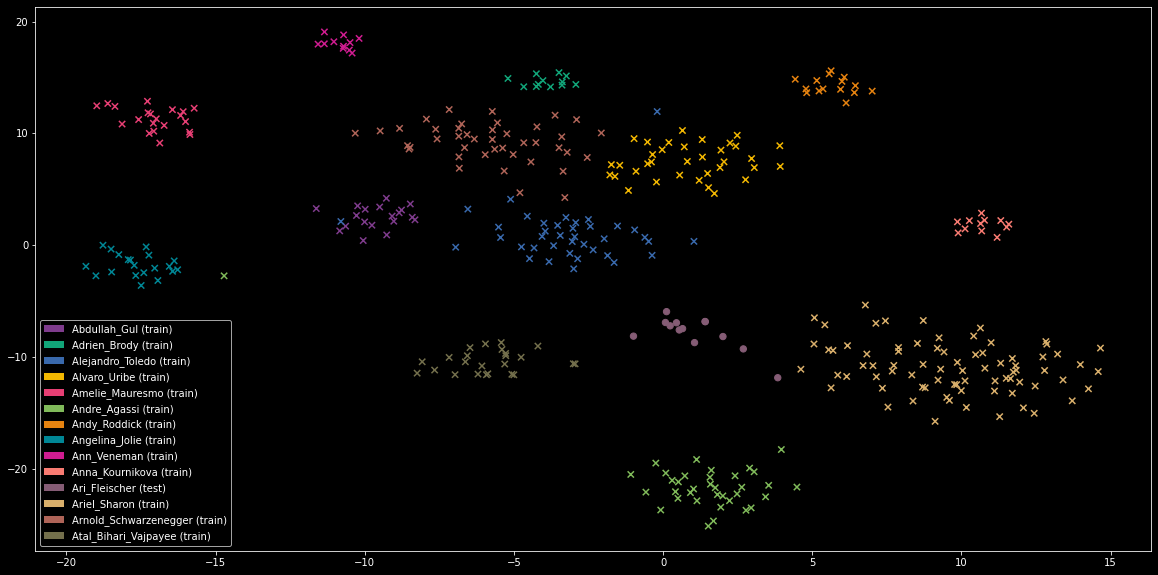

In [ ]:
emb = model.my_conv_model.predict(all_imgs, batch_size=32)
visualize_embeddings(emb)